In [285]:
import Base.show
using DataFrames
using Random

import Pkg
#Pkg.add("Graphs")
using Graphs

#Pkg.add("GraphRecipes")
#Pkg.add("Plots")
using Plots, GraphRecipes

In [286]:
mutable struct Cohesin
    processivity::Int64
    alive::Int64
    left_pos::Int64
    right_pos::Int64
    left_blocked::Bool
    right_blocked::Bool
    left_ctcf_captured::Bool
    right_ctcf_captured::Bool
    extruded_beads::Array{Bool}
    
    function Cohesin(processivity, polymer_length, alive=0)
        loading_pos = rand(1:polymer_length)
        new(processivity, alive, loading_pos, loading_pos, false, false, false, false, fill(false, polymer_length))
    end
end
    
function Base.show(io::IO, object::Cohesin) 
        left_blocked_str = string((object.left_blocked) ? " (Cohesin blocked)" : "", 
                                  (object.left_ctcf_captured) ? " (CTCF captured)" : "")
        right_blocked_str = string((object.right_blocked) ? " (Cohesin blocked)" : "", 
                                   (object.right_ctcf_captured) ? " (CTCF captured)" : "") 
        print(io, string("Lived ", object.alive, " of ", object.processivity, " - "), 
                  string("Anchors: ", object.left_pos, left_blocked_str, ", ", object.right_pos, right_blocked_str, " - "), 
                  string("Extruded beads:", findall(object.extruded_beads), "\n")) 
end


In [287]:
mutable struct Sim
    polymer_length::Int64
    bead_size::Int64
    cohesins::Array{Cohesin}
    plus_ctcfs::DataFrame
    minus_ctcfs::DataFrame
    occupied_positions::Array{Bool}
    processivity::Float64
    ctcf_capture_rate::Float64
    ctcf_stabilization_factor::Int64
    extruded_beads::Array{Bool}
    bead_graph::SimpleGraph
    
    function Sim(n, polymer_length_bp=1e6, processivity_bp=150e3, bead_size = 1e3, 
                 ctcf_capture_rate=0.25, ctcf_stabilization_factor=4, plus_ctcfs=missing,
                 minus_ctcfs=missing)
        # Define polymer_length and processity in bead units
        polymer_length = Int(polymer_length_bp/bead_size)
        processivity = processivity_bp / bead_size
        occupied_positions = fill(false, polymer_length)
        alive = 0
        cohesins = []
        bead_graph = path_graph(polymer_length)
        for i in 1:n
            collision = true
            while (collision) 
                global coh = Cohesin(processivity, polymer_length, alive)
                if (!occupied_positions[coh.left_pos])
                    collision = false
                end
            end
            occupied_positions[coh.left_pos] = true
            alive = round(alive + processivity/n)
            push!(cohesins, coh)
            add_edge!(bead_graph, coh.left_pos, copy(coh.left_pos))
        end
        empty_ctcf_df = DataFrame(pos_bp=Float64[], pos=Int64[], occupancy_rate=Float64[], bound_cohesin=Bool[])
        if ismissing(plus_ctcfs)
            plus_ctcfs = deepcopy(empty_ctcf_df)
        end
        if ismissing(minus_ctcfs)
            minus_ctcfs = deepcopy(empty_ctcf_df)
        end
        new(polymer_length, bead_size, cohesins, plus_ctcfs, minus_ctcfs, occupied_positions, 
            processivity, ctcf_capture_rate, ctcf_stabilization_factor, fill(false, polymer_length), bead_graph)            
    end
end

function Base.show(io::IO, object::Sim)
    print(io, string("Cohesin positions: ", findall(object.occupied_positions), "\n"),
              string("Extruded beads: ", sum(object.extruded_beads), " of ", object.polymer_length, "\n"),
              string("Plus CTCF positions (bound fraction): ", object.plus_ctcfs.pos_bp, 
                        "(", object.plus_ctcfs.occupancy_rate, ") ", "\n"),
              string("Minus CTCF positions (bound fraction): ", object.minus_ctcfs.pos_bp, 
                        "(", object.minus_ctcfs.occupancy_rate, ") ", "\n"), "Individual cohesins:")
    for coh in object.cohesins 
        show(coh)
    end
end

In [288]:
function add_ctcf(object::Sim, orientation, pos_bp, occupancy_rate=1) 
    if orientation=="+" 
        push!(object.plus_ctcfs, (pos_bp, ceil(pos_bp/object.bead_size), occupancy_rate, false))
        sort!(object.plus_ctcfs, :pos_bp, rev=true)
    end
    if orientation=="-"
        push!(object.minus_ctcfs, (pos_bp, ceil(pos_bp/object.bead_size), occupancy_rate, false))
        sort!(object.minus_ctcfs, :pos_bp, rev=false)
    end
    object
end

add_ctcf (generic function with 2 methods)

In [289]:
function delete_ctcf(object::Sim, pos_bp)
    idx = indexin(pos_bp, object.plus_ctcfs.pos_bp)[1]
    if idx != nothing
        delete!(object.plus_ctcfs, [idx])
    end
    idx = indexin(pos_bp, object.minus_ctcfs.pos_bp)[1]
    if idx != nothing
        delete!(object.minus_ctcfs, [idx])
    end
    object
end

delete_ctcf (generic function with 1 method)

In [306]:
function advance(object::Sim)
    occupied_positions = object.occupied_positions
    for i in 1:length(object.cohesins)
        coh = object.cohesins[i]
        coh.alive += 1
        if coh.alive >= coh.processivity
            # println("Cohesin fell off!")
            rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
            occupied_positions[coh.left_pos] = false
            occupied_positions[coh.right_pos] = false
            # Release CTCF (if any)
            idx = indexin(coh.left_pos, object.plus_ctcfs.pos)[1]
            if idx != nothing
                object.plus_ctcfs.bound_cohesin[idx] = false
            end
            idx = indexin(coh.right_pos, object.minus_ctcfs.pos)[1]
            if idx != nothing
                object.minus_ctcfs.bound_cohesin[idx] = false
            end
            # Generate a new one (making sure it doesn't overlap an existing one)
            collision = true
            while (collision)
                coh = Cohesin(object.processivity, object.polymer_length)
                if (!occupied_positions[coh.left_pos])
                    collision = false
                end
            end
            occupied_positions[coh.left_pos] = true
            add_edge!(object.bead_graph, coh.left_pos, coh.left_pos) 
        else
            # LEFT
            new_left = coh.left_pos - 1
            if (!coh.left_ctcf_captured)
                # Left side captured by a CTCF?
                for idx in findall((object.plus_ctcfs.pos .== new_left) .& (object.plus_ctcfs.bound_cohesin .== false))
                    if rand(Float64) < object.plus_ctcfs.occupancy_rate[idx] * object.ctcf_capture_rate
                        # println("Captured!")
                        object.plus_ctcfs.bound_cohesin[idx] = true
                        coh.left_ctcf_captured = true
                        coh.processivity = object.processivity * object.ctcf_stabilization_factor
                    end
                end
                if (new_left>=1) 
                    if (occupied_positions[new_left]==false)
                        coh.left_blocked = false
                        if coh.left_pos != coh.right_pos
                            occupied_positions[coh.left_pos] = false
                        end
                        rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
                        add_edge!(object.bead_graph, new_left, coh.right_pos)
                        coh.left_pos = new_left
                        occupied_positions[new_left] = true
                    end
                else
                    coh.left_blocked = true
                end
            end
            # RIGHT
            new_right = coh.right_pos + 1
            if (!coh.right_ctcf_captured)
                # Right side captured by a CTCF?
                for idx in findall((object.minus_ctcfs.pos .== new_right) .& (object.minus_ctcfs.bound_cohesin .== false))
                    if rand(Float64) < object.minus_ctcfs.occupancy_rate[idx] * object.ctcf_capture_rate
                        # println("Captured!")
                        object.minus_ctcfs.bound_cohesin[idx] = true
                        coh.right_ctcf_captured = true
                        coh.processivity = object.processivity * object.ctcf_stabilization_factor
                    end
                end
                if (new_right<=object.polymer_length)
                    if (occupied_positions[new_right]==false)
                        coh.right_blocked = false
                        if coh.left_pos != coh.right_pos
                            occupied_positions[coh.right_pos] = false
                        end
                        rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
                        add_edge!(object.bead_graph, coh.left_pos, new_right)
                        coh.right_pos = new_right
                        occupied_positions[new_right] = true
                    end
                else
                    coh.right_blocked = true
                end
            end
            if coh.right_pos - coh.left_pos >= 2
                coh.extruded_beads[((coh.left_pos+1):(coh.right_pos-1))] .= true
            end
        end
        object.cohesins[i] = coh
    end
    object.occupied_positions = occupied_positions
    extruded_beads_sum = fill(false, object.polymer_length)
    for coh in object.cohesins
        extruded_beads_sum = extruded_beads_sum .| coh.extruded_beads
    end
    object.extruded_beads = extruded_beads_sum
    object
end

advance (generic function with 1 method)

In [307]:
function effective_dist(object::Sim, pointA::Int64, pointB::Int64)
    length(a_star(object.bead_graph, pointA, pointB))
end

effective_dist (generic function with 1 method)

In [308]:
function plot_fiber(object::Sim, xmin=nothing, xmax=nothing, main=nothing)
    
end

plot_fiber (generic function with 4 methods)

# Test example:

In [318]:
object = Sim(10)
for i in 1:20000
    advance(object)
end
object

Cohesin positions: [134, 144, 184, 291, 292, 293, 306, 316, 400, 476, 477, 537, 639, 736, 737, 803, 817, 910, 911, 975]
Extruded beads: 714 of 1000
Plus CTCF positions (bound fraction): Float64[](Float64[]) 
Minus CTCF positions (bound fraction): Float64[](Float64[]) 
Individual cohesins:

Lived 50 of 150 - Anchors: 911, 975 - Extruded beads:[912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974]
Lived 65 of 150 - Anchors: 817, 910 - Extruded beads:[818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909]
Lived 80 of 150 - Anchors: 293, 400 - Extruded beads:[294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306

In [311]:
object

Cohesin positions: [241, 281, 396, 436, 684, 724, 762, 802, 902, 942]
Extruded beads: 195 of 1000
Plus CTCF positions (bound fraction): Float64[](Float64[]) 
Minus CTCF positions (bound fraction): Float64[](Float64[]) 
Individual cohesins:

Lived 20 of 150 - Anchors: 241, 281 - Extruded beads:[242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280]
Lived 50 of 150 - Anchors: 684, 724 - Extruded beads:[685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723]
Lived 80 of 150 - Anchors: 762, 802 - Extruded beads:[763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801]
Lived 110 of 150 - Anchors: 902, 942 - Extruded beads:[903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941]
Liv

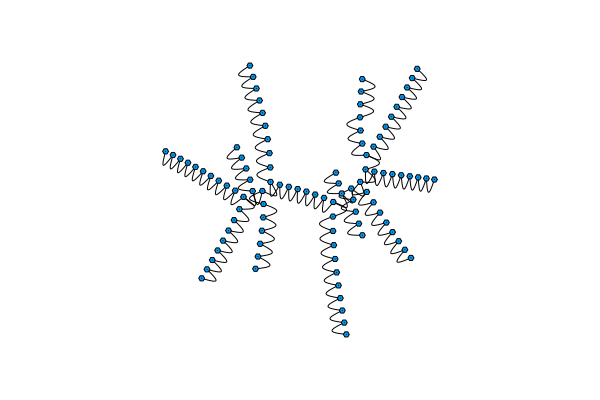

In [283]:
graphplot(object.bead_graph)

In [301]:
x = [1,2,3,4,5]

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [304]:
x[5]

5